In [44]:
import geopandas as gdp
import pandas as pd
from gerrychain import Graph, Partition, Election, MarkovChain, proposals, updaters, constraints, accept, GeographicPartition
from gerrychain.constraints import single_flip_contiguous 
from gerrychain.proposals import recom
from gerrychain.accept import cut_edge_accept
from gerrychain.updaters import Tally, cut_edges
from networkx import is_connected, connected_components
from functools import partial
import os

In [2]:
default_path = os.path.join(os.getcwd(), "..", "shapefiles", "processed")
FL_path = os.path.join(default_path, "florida", "precinct_level_w_election.shp")
UT_path = os.path.join(default_path, "utah", "UTAH_VTDs.shp")
NC_path = os.path.join(default_path, "north carolina", "precinct_level_w_election.shp")

In [3]:
FL_graph = Graph.from_file(FL_path, ignore_errors=True)
UT_graph = Graph.from_file(UT_path, ignore_errors=True)
NC_graph = Graph.from_file(NC_path, ignore_errors=True)

/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(539, 543), (1482, 3632), (3175, 3179), (4655, 4685), (1054, 1793), (4689, 4696), (770, 1607), (1321, 2384), (4006, 4010), (4225, 4314), (3998, 4006), (1520, 1547), (2830, 3935), (1718, 2596), (159, 178), (3478, 3482), (3529, 3564), (4006, 4028), (1505, 1567), (4599, 4622), (3068, 3089), (3270, 3322), (3910, 3911), (3100, 3121), (3709, 3741), (4377, 4713), (3068, 3107), (1831, 1

/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:169: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column TOT_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column WHITE_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column ASN_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column BLK_P

/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column SbPrcnc!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column AliasNm!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column R_VOTES!
  warnings.warn("NA values f

In [4]:
FL_graph.islands
FL_components = list(connected_components(FL_graph))
[len(c) for c in FL_components]

[4790, 2, 1, 3, 3, 1, 3, 1, 2]

/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '57' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '658' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '665' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '2797' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/anaconda3/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '2799' for attribute 'population' with fields ['TOT_POP']
 

{'03': 1013123.0,
 '22': 893191.0,
 '20': 853144.0,
 '23': 687740.0,
 '24': 900444.0,
 '05': 1058763.0,
 'n/a': 511076.0,
 '06': 660129.0,
 '14': 774782.0,
 '15': 713648.0,
 '01': 821693.0,
 '19': 552165.0,
 '04': 638783.0,
 '10': 507642.0,
 '07': 645739.0,
 '09': 924057.0,
 '08': 662356.0,
 '13': 1236646.0,
 '18': 911380.0,
 '27': 1067515.0,
 '26': 912281.0,
 '21': 1400108.0}

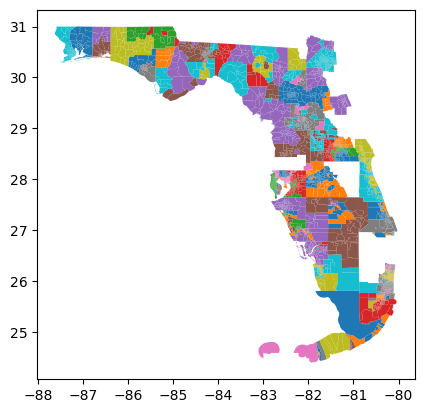

In [8]:
FL_init_partition = Partition(FL_graph, assignment="CONG_DIST", updaters=FL_updaters)
FL_init_partition.plot()
FL_init_partition["population"]

{1.0: 689746.3708065399,
 2.0: 692362.7309064252,
 3.0: 689861.0370456532,
 4.0: 692085.9179166325}

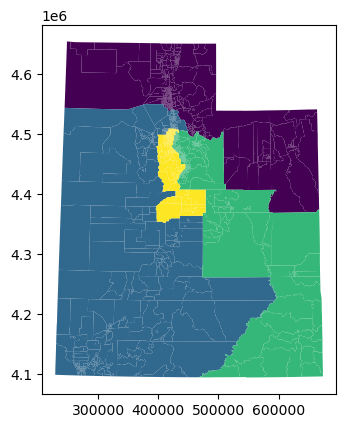

In [27]:
UT_init_partition = GeographicPartition(UT_graph, assignment="CD", updaters=UT_updaters)
UT_init_partition.plot()
UT_init_partition["population"]

In [25]:
NC_election = Election("SEN", {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

{'13': 735212,
 '5': 734991,
 '9': 729146,
 '11': 731704,
 '3': 731979,
 '1': 736218,
 '7': 735654,
 '8': 734098,
 '10': 725405,
 '4': 737394,
 '6': 733230,
 '12': 736885,
 '2': 733567}

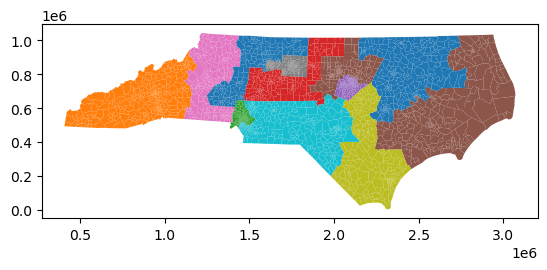

In [28]:
NC_init_partition = GeographicPartition(NC_graph, assignment="CD", updaters={"population": Tally("TOTPOP", alias="population"),
        "cut_edges": cut_edges,
        "SEN": NC_election})
NC_init_partition.plot()
NC_init_partition["population"]

In [11]:
FL_ideal_pop = sum(FL_init_partition["population"].values()) / len(FL_init_partition)
FL_proposal = partial(recom, pop_col="TOT_POP", pop_target=FL_ideal_pop, epsilon=.02, node_repeats=2)
FL_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(FL_init_partition["cut_edges"])
)
FL_pop_constraint = constraints.within_percent_of_ideal_population(FL_init_partition, 0.02)

In [12]:
UT_ideal_pop = sum(UT_init_partition["population"].values()) / len(UT_init_partition)
UT_proposal = partial(recom, pop_col="TOTPOP", pop_target=UT_ideal_pop, epsilon=.02, node_repeats=2)
UT_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(UT_init_partition["cut_edges"])
)
UT_pop_constraint = constraints.within_percent_of_ideal_population(UT_init_partition, 0.02)

In [52]:
NC_ideal_pop = sum(NC_init_partition["population"].values()) / len(NC_init_partition)
NC_proposal = partial(recom, pop_col="TOTPOP", pop_target=NC_ideal_pop, epsilon=.02, node_repeats=2)
NC_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(NC_init_partition["cut_edges"])
)
NC_pop_constraint = constraints.within_percent_of_ideal_population(NC_init_partition, 0.02)

In [14]:
iterations = 100
# FL_chain = MarkovChain(
#     proposal=FL_proposal,
#     constraints=[
#         FL_pop_constraint,
#         FL_compactness_bound
#     ],
#     accept=accept.always_accept,
#     initial_state=FL_init_partition,
#     total_steps=iterations
# )

In [15]:
UT_chain = MarkovChain(
    proposal=UT_proposal,
    constraints=[
        UT_pop_constraint,
        UT_compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=UT_init_partition,
    total_steps=iterations
)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

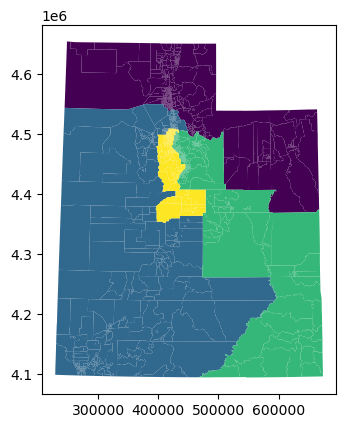

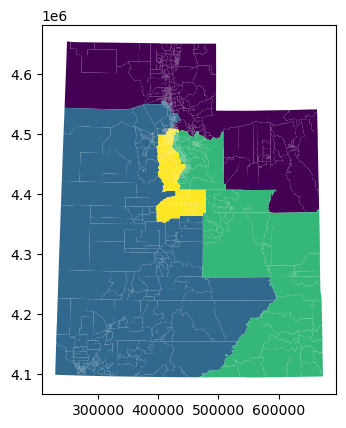

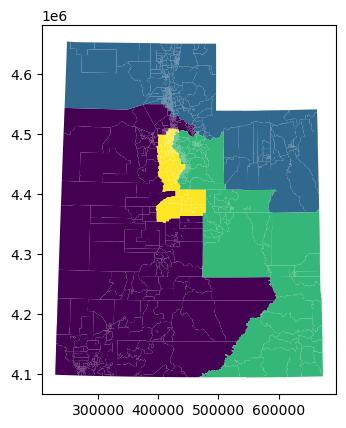

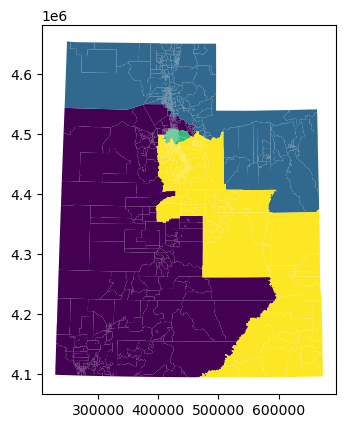

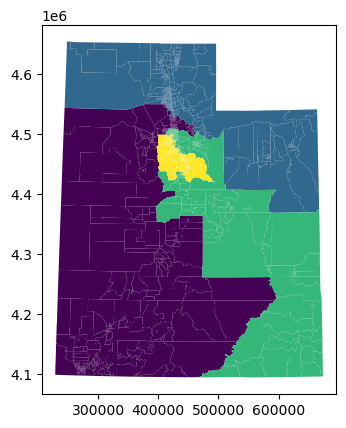

In [32]:
i = 0
for p in UT_chain:
    if i == 5:
        break
    display(p.plot())
    i += 1

In [53]:
NC_chain = MarkovChain(
    proposal=NC_proposal,
    constraints=[
        NC_pop_constraint,
        NC_compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=NC_init_partition,
    total_steps=5
)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

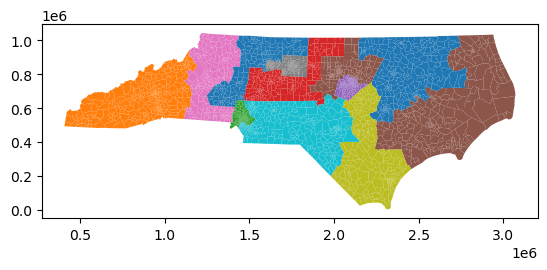

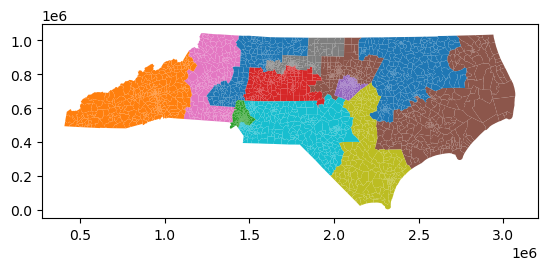

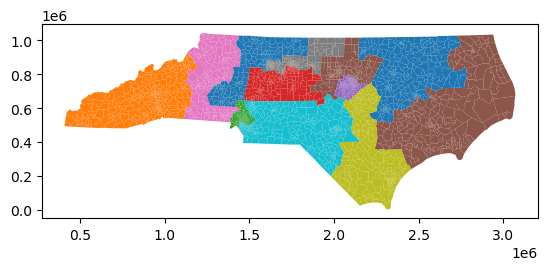

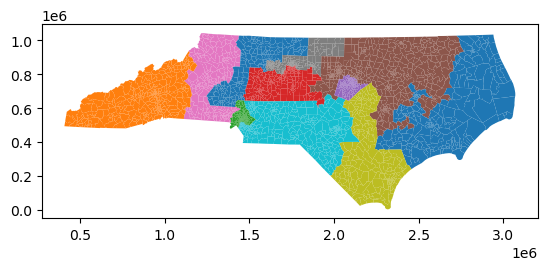

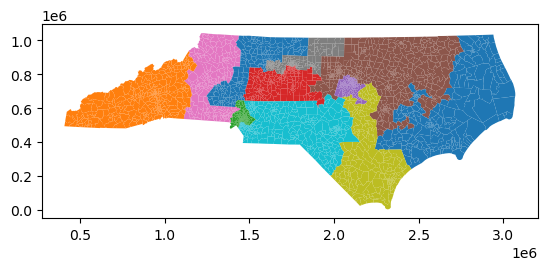

In [56]:
i = 0
for p in NC_chain:
    if i == 5:
        break
    display(p.plot())
    i += 1

In [ ]:
print("Done")